In [3]:
# Grundlegende Bibliotheken
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
#import statsmodels.api as sm

In [6]:
# Einstellungen für bessere Plots
plt.rcParams['figure.figsize'] = (10, 6)

# Pandas Optionen
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [5]:
path = kagglehub.dataset_download("priyamchoksi/credit-card-transactions-dataset")

ds = pd.read_csv(f"{path}/credit_card_transactions.csv")


In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(s, bins="fd", color="pink", edgecolor="purple", stat="count")
plt.xscale("log")
plt.title("Verteilung: Amt (log-Skala)")
plt.xlabel("Amt (log)")
plt.ylabel("Anzahl")
plt.legend()
plt.show()
#Ich habe die x-Achse auf eine logarithmische Skala gesetzt, um die Verteilung besser darzustellen. Provisorisch falls wir das für die 3. Vorlesung brauchen

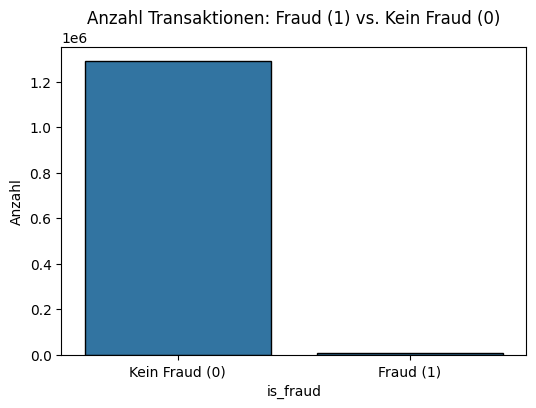

In [13]:
plt.figure(figsize=(6,4))
sns.countplot(x="is_fraud", data=ds, edgecolor="black")

plt.title("Anzahl Transaktionen: Fraud (1) vs. Kein Fraud (0)")
plt.xlabel("is_fraud")
plt.ylabel("Anzahl")
plt.xticks([0, 1], ["Kein Fraud (0)", "Fraud (1)"])
plt.show()


In [15]:
#Online ausgaben im verleich Frau zu Mann und nur Frau mehr net_shopping oder wie sieht es aus in der verteilung ( category mit Geschlecht vergleichen )
ds["category"].unique()
ds["category"].nunique()
ds["category"].value_counts()

category
gas_transport     131659
grocery_pos       123638
home              123115
shopping_pos      116672
kids_pets         113035
shopping_net       97543
entertainment      94014
food_dining        91461
personal_care      90758
health_fitness     85879
misc_pos           79655
misc_net           63287
grocery_net        45452
travel             40507
Name: count, dtype: int64


Wir wollen anschauen, welches Geschlecht in welcher Kategorie mehr Transaktionen durchgeführt hat. Dazu haben wir zuerst Vermutungen zu den Kategorien aufgestellt

- misc_net: Keine Vermutung da dies die Daten von nicht zugeordneten online Transaktionen sind
- misc_pos: Keine Vermutung da dies die Daten von nicht zugeordneten physischen Transaktionen sind
- grocery_pos: Mehr Frauen haben diese Transaktionen durchgeführt
- grocery_net Mehr Frauen haben diese Transaktionen durchgeführt
- entertainment: Mehr Männer haben diese Transaktionen durchgeführt
- gas_transport: Mehr Männer haben diese Transaktionen durchgeführt
- shopping_net: Mehr Frauen haben diese Transaktionen durchgeführt
- shopping_pos: Mehr Frauen haben diese Transaktionen durchgeführt
- food_dining: Mehr Männer haben diese Transaktionen durchgeführt
- personal_care: Mehr Frauen haben diese Transaktionen durchgeführt
- health fitness: Wir denken hier sind beide Geschlechter gleich auf oder die Frauen leicht im mehr.
- travel: Mehr Männer haben diese Transaktionen durchgeführt
- kids_pets: Mehr Männer haben diese Transaktionen durchgeführt
- home: Mehr Männer haben diese Transaktionen durchgeführt





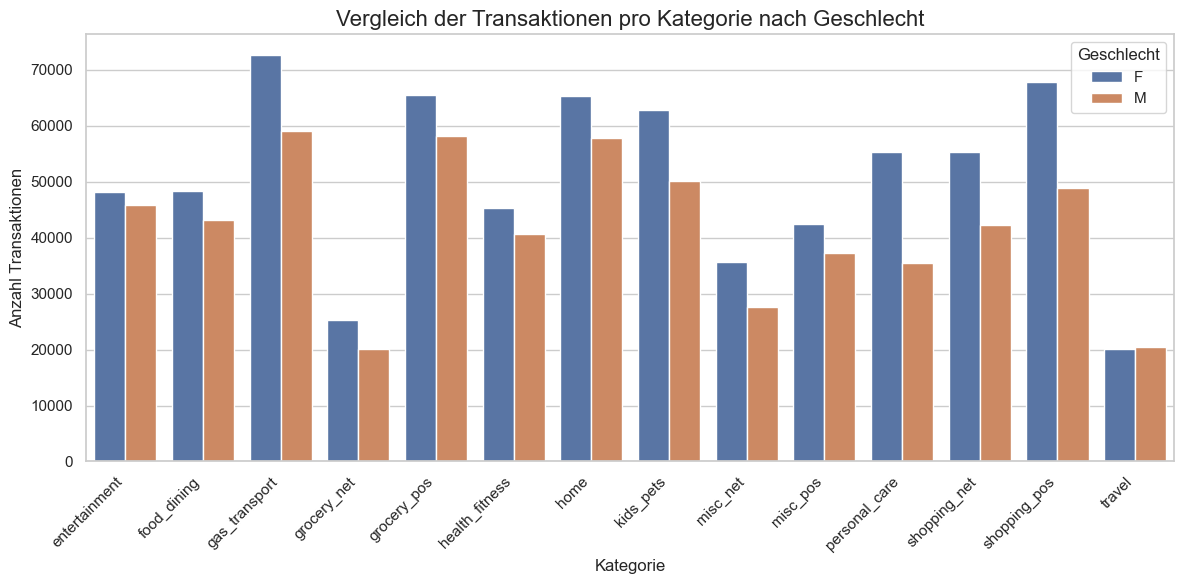

In [16]:
sns.set(style="whitegrid")

# Gruppieren nach Kategorie und Geschlecht und die Anzahl zählen
category_gender_counts = ds.groupby(['category', 'gender']).size().reset_index(name='count')

# Balkendiagramm erstellen
plt.figure(figsize=(12, 6))
sns.barplot(x='category', y='count', hue='gender', data=category_gender_counts)

# Diagramm anpassen
plt.title("Vergleich der Transaktionen pro Kategorie nach Geschlecht", fontsize=16)
plt.xlabel("Kategorie", fontsize=12)
plt.ylabel("Anzahl Transaktionen", fontsize=12)
plt.xticks(rotation=45, ha='right')  # x-Achsenbeschriftungen lesbar machen
plt.legend(title='Geschlecht')
plt.tight_layout()